In [4]:
# just import statements
import time
import numpy as np
import simple_wta, convex_relaxation, regret_matching, spectral_clustering, ahuja

In [1]:
# creating a random WTA problem
n_weapons = 300
n_targets = 175
prob = simple_wta.random_wta_factory(n_weapons, n_targets)
print(type(prob))

# target values are stored in WTAProblem.v
print(np.shape(prob.v))

# pk data is stored in WTAProblem.p
print(np.shape(prob.p))

# specific WTA problems can be constructed by passing a
# value vector and pk matrix to the class constructor
copy_problem = simple_wta.WTAProblem(prob.v.copy(),prob.p.copy())

NameError: name 'simple_wta' is not defined

In [83]:
# An upper bound on the optimal WTA objective can be found 
# by replacing the WTA problem with a knapsack problem, and optimizing
# in greedy fashion.

# this is implemented according to the Ahuja paper

# "combinatorial lower-bounding (clb) maximum marginal return (mmr) algorithm"
t0 = time.perf_counter()
x = simple_wta.clb_mmr_alg(prob)
t1 = time.perf_counter()
print("solution found in %.3f seconds." % (t1-t0))
print("objective value %.1f" % prob.objective(x))

solution found in 0.003 seconds.
objective value 318.5


In [84]:
# now gonna fuck with the ahuja code
t0 = time.perf_counter()
x = ahuja.optimize(prob)
t1 = time.perf_counter()
print("solution found in %.3f seconds." % (t1-t0))
print("objective value %.1f" % prob.objective(x))

solution found in 88.913 seconds.
objective value 22.0


In [73]:
# We can use a multi-agent reinforcement learning algorithm
# directly on the original problem.

# Run regret-matching for 50 rounds and sample a random action profile
# from a probability distribution derived from the regret vectors.
rounds = 50
t0 = time.perf_counter()
x,P,R = regret_matching.learning_dynamics(prob, rounds)
t1 = time.perf_counter()

print("solution found in %.1f seconds." % (t1-t0))
print("solution time divided by # weapons %.1f" % ((t1-t0)/n_weapons))
print("mixed strategy objective value %.1f" % prob.mixed_objective(P))
print("argmax stragey objective value %.1f" % prob.objective(np.argmax(P,1)))

# this is an improvement over the maximum-marginal-return approach
# but comes at significant computaitonal cost.

# However, in practice the bulk of the computations are done in parallel
# (each weapon only computes their own regret).

KeyboardInterrupt: 

In [74]:
# now we will demonstrate scaling improvements afforded by
# partitioning the large WTA problem into smaller subproblems.

# first we will do this randomly.

n_clusters = int(np.sqrt(n_weapons))
sub_problems, coalitions, missions = spectral_clustering.random_reduction(prob, n_clusters)

t0 = time.perf_counter()
rounds = 150
actions = [regret_matching.learning_dynamics(prob,rounds)[1] for prob in sub_problems]
value1 = np.sum([sub_problems[i].mixed_objective(actions[i]) for i in range(n_clusters)])
value2 = np.sum([sub_problems[i].objective(np.argmax(actions[i],1)) for i in range(n_clusters)])
t1 = time.perf_counter()

print("solution found in %.1f seconds." % (t1-t0))
print("solution time divided by (# weapons) %.3f" % ((t1-t0)/(n_weapons)))
print("mixed strategy objective value %.1f" % value1)
print("argmax stragey objective value %.1f" % value2)

# its apparent that the divide-and-conquer strategy drastically accelerates
# learning

solution found in 33.0 seconds.
solution time divided by (# weapons) 0.132
mixed strategy objective value 133.9
argmax stragey objective value 133.7


In [75]:
# finally we will demonstrate the objective improvements when spectral clustering is applied

t0 = time.perf_counter()
sub_problems, coalitions, missions = spectral_clustering.reduce_problem(prob, n_clusters)
rounds = 150
actions = [regret_matching.learning_dynamics(prob,rounds)[1] for prob in sub_problems]
value1 = np.sum([sub_problems[i].mixed_objective(actions[i]) for i in range(n_clusters)])
value2 = np.sum([sub_problems[i].objective(np.argmax(actions[i],1)) for i in range(n_clusters)])
t1 = time.perf_counter()

print("solution found in %.1f seconds." % (t1-t0))
print("solution time divided by (# weapons) %.3f" % ((t1-t0)/(n_weapons)))
print("mixed strategy objective value %.1f" % value1)
print("argmax stragey objective value %.1f" % value2)

# obviously, spectral clustering is better than random clustering

solution found in 37.6 seconds.
solution time divided by (# weapons) 0.150
mixed strategy objective value 70.0
argmax stragey objective value 68.1


In [87]:
# what about ahuja algorithm on random clusters?
t0 = time.perf_counter()
sub_problems, coalitions, missions = spectral_clustering.random_reduction(prob, n_clusters)
rounds = 100
actions = [ahuja.optimize(prob) for prob in sub_problems]
value = np.sum([sub_problems[i].objective(actions[i]) for i in range(n_clusters)])
t1 = time.perf_counter()

print("solution found in %.1f seconds." % (t1-t0))
print("value %.1f" % value)

solution found in 1.6 seconds.
value 47.9


In [88]:
# what about ahuja algorithm on spectral clusters? 

t0 = time.perf_counter()
sub_problems, coalitions, missions = spectral_clustering.reduce_problem(prob, n_clusters)
actions = [ahuja.optimize(prob) for prob in sub_problems]
value = np.sum([sub_problems[i].objective(actions[i]) for i in range(n_clusters)])
t1 = time.perf_counter()
print("solution found in %.3f seconds." % (t1-t0))
print("objective value %.1f" % value)

c:\Python39\lib\site-packages\numpy\lib\function_base.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


solution found in 3.136 seconds.
objective value 29.7


In [2]:
"""
I'm going to compare solution quality and run time of several different
methods at various problem scales
"""

# number of clusters 
# L = np.array([10,12,14,16,18,20,22])
L = np.array([10,12,14,16,18])

# number of weapons
N = L**2
# number of targets
M = np.array(0.75*N,dtype=int)
# WTA problems
problems = [simple_wta.random_wta_factory(N[i],M[i]) for i in range(len(N))]
f1 = np.zeros(len(N))          # objective value for ahuja's method on full problem
f2 = np.zeros((len(N),10))    # objective value for ahuja's method on 100 random coalitions
f3 = np.zeros(len(N))          # objective value for ahuja's method with spectral clustering
# runnign times
t1 = np.zeros(len(N))
t2 = np.zeros((len(N),10))
t3 = np.zeros(len(N))

for i in range(len(problems)):
    tstart = time.perf_counter()
    f1[i] = problems[i].objective(ahuja.optimize(problems[i],maxiters=1000))
    t1[i] = time.perf_counter()-tstart

    for j in range(10):
        tstart = time.perf_counter()
        sub_problems, coalitions, missions = spectral_clustering.random_reduction(problems[i], L[i])
        f2[i,j] = np.sum([p.objective(ahuja.optimize(p,maxiters=1000)) for p in sub_problems])
        t2[i,j] = time.perf_counter()-tstart
    
    tstart = time.perf_counter()
    sub_problems, coalitions, missions = spectral_clustering.reduce_problem(problems[i], L[i])
    f3[i] = np.sum([p.objective(ahuja.optimize(p,maxiters=1000)) for p in sub_problems])
    t3[i] = time.perf_counter()-tstart


c:\Python39\lib\site-packages\numpy\lib\function_base.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
c:\Python39\lib\site-packages\numpy\lib\function_base.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
c:\Python39\lib\site-packages\numpy\lib\function_base.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

GRAPH IS EMPTY DURING ASSIGNMENT UPDATE!!


c:\Python39\lib\site-packages\numpy\lib\function_base.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
c:\Python39\lib\site-packages\numpy\lib\function_base.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
c:\Python39\lib\site-packages\numpy\lib\function_base.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

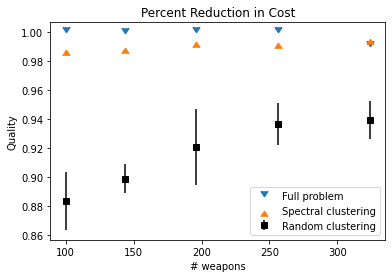

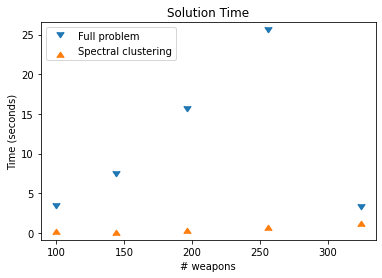

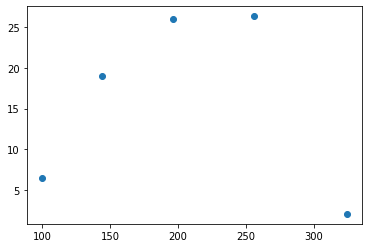

In [3]:
from matplotlib import pyplot as plt 
lower_bound = np.array([simple_wta.comb_lower_bound_obj(p,simple_wta.clb_mmr_alg(p)) for p in problems])
upper_bound = np.array([np.sum(p.v) for p in problems])
f2mean = np.average(f2,1)
f2stddev = np.std(f2,1)
t2mean = np.average(t2,1)
t2stddev = np.std(t2,1)
fig1 = plt.figure()
plt.scatter(N,(upper_bound-f1)/(upper_bound-lower_bound),marker=7,s=50)
plt.errorbar(N,(upper_bound-f2mean)/(upper_bound-lower_bound),(f2stddev)/(upper_bound-lower_bound),fmt="s",color='black')
plt.scatter(N,(upper_bound-f3)/(upper_bound-lower_bound),marker=6,s=50)
# plt.scatter(N,(upper_bound-baseline)/(upper_bound-lower_bound),marker="D")
plt.xlabel("# weapons")
plt.ylabel("Quality")
plt.title("Percent Reduction in Cost")
plt.legend(["Full problem", "Spectral clustering", "Random clustering"])
fig1.savefig("quality.png")
fig2 = plt.figure()
plt.scatter(N,t1,marker=7,s=50)
# plt.scatter(N,t2mean)
plt.scatter(N,t3,marker=6,s=50)
plt.xlabel("# weapons")
plt.ylabel("Time (seconds)")
plt.title("Solution Time")
plt.legend(["Full problem", "Spectral clustering"])
fig2.savefig("solution time.png")
t3/t1
fig3 = plt.figure()
plt.scatter(N,t1/t3)


In [118]:
# comparing weapon / target cluster sizes from spectral clustering
n_weapons = 225
n_targets = int(0.75*n_weapons)
n_clusters = int(np.sqrt(n_weapons))
p = simple_wta.random_wta_factory(n_weapons,n_targets)
problems, coalitions, missions = spectral_clustering.reduce_problem(p,n_clusters)
c_sizes = [len(c) for c in coalitions]
m_sizes = [len(m) for m in coalitions]
[np.average(c_sizes), np.std(c_sizes), np.min(c_sizes), np.max(c_sizes)]


[15.0, 4.560701700396552, 7, 23]

In [119]:
# comparing weapon / target cluster sizes for random clustering
n_weapons = 225
n_targets = int(0.75*n_weapons)
n_clusters = int(np.sqrt(n_weapons))
p = simple_wta.random_wta_factory(n_weapons,n_targets)
problems, coalitions, missions = spectral_clustering.random_reduction(p,n_clusters)
c_sizes = [len(c) for c in coalitions]
m_sizes = [len(m) for m in coalitions]
[np.average(c_sizes), np.std(c_sizes), np.min(c_sizes), np.max(c_sizes)]


[15.0, 4.88535225614967, 7, 22]

In [205]:
"""
Comparing solution quality between regret matching on spectral clusters against
ahuja's method on the full problem.
"""

# number of clusters 
L = np.array([10,12,14,16])
# number of weapons
N = L**2
# number of targets
M = np.array(0.75*N,dtype=int)
    # WTA problems
problems = [simple_wta.random_wta_factory(N[i],M[i]) for i in range(len(N))]
f1 = np.zeros(len(N))          # objective value for ahuja's method on full problem
f2 = np.zeros(len(N))          # objective value for regret matching method with spectral clustering
# runnign times
t1 = np.zeros(len(N))
t2 = np.zeros((len(N)))

for i in range(len(problems)):
    tstart = time.perf_counter()
    f1[i] = problems[i].objective(ahuja.optimize(problems[i],maxiters=1000))
    t1[i] = time.perf_counter()-tstart

    
    tstart = time.perf_counter()
    sub_problems, coalitions, missions = spectral_clustering.reduce_problem(problems[i], L[i])
    actions = [np.argmax(regret_matching.learning_dynamics(p,200)[1],1) for p in sub_problems]
    f2[i] = np.sum([sub_problems[i].objective(actions[i]) for i in range(len(actions))])
    t2[i] = time.perf_counter()-tstart


c:\Python39\lib\site-packages\numpy\lib\function_base.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
c:\Python39\lib\site-packages\numpy\lib\function_base.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)
c:\Python39\lib\site-packages\numpy\lib\function_base.py:959: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

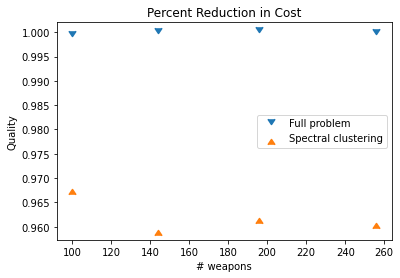

In [206]:

from matplotlib import pyplot as plt 
lower_bound = np.array([simple_wta.comb_lower_bound_obj(p,simple_wta.clb_mmr_alg(p)) for p in problems])
upper_bound = np.array([np.sum(p.v) for p in problems])
fig1 = plt.figure()
plt.scatter(N,(upper_bound-f1)/(upper_bound-lower_bound),marker=7,s=50)
plt.scatter(N,(upper_bound-f2)/(upper_bound-lower_bound),marker=6,s=50)
# plt.scatter(N,(upper_bound-baseline)/(upper_bound-lower_bound),marker="D")
plt.xlabel("# weapons")
plt.ylabel("Quality")
plt.title("Percent Reduction in Cost")
plt.legend(["Full problem", "Spectral clustering", "Random clustering"])
fig1.savefig("quality.png")
# fig2 = plt.figure()
# plt.scatter(N,t1,marker=7,s=50)
# # plt.scatter(N,t2mean)
# plt.scatter(N,t3,marker=6,s=50)
# plt.xlabel("# weapons")
# plt.ylabel("Time (seconds)")
# plt.title("Solution Time")
# plt.legend(["Full problem", "Spectral clustering"])
# fig2.savefig("solution time.png")
# t3/t1
# fig3 = plt.figure()
# plt.scatter(N,t1/t3)
